# PTAL Analysis of Jaipur - JCTSL Bus Services

This notebook downloads data geometry data from open street maps and calculates the public transport accessibility level (PTAL) for the bus services provided by Jaipur City Transport Services Limited (JCTSL). The bus routes data used in this study is taken from the [JCTSL website](https://www.bing.com/ck/a?!&&p=d2e6afe3960a94fcJmltdHM9MTcwODMwMDgwMCZpZ3VpZD0zNGY0ZGIzNi0zYjFmLTYyNTgtMGIxMi1jZjEwM2E1ZjYzYjYmaW5zaWQ9NTIwMg&ptn=3&ver=2&hsh=3&fclid=34f4db36-3b1f-6258-0b12-cf103a5f63b6&psq=jctsl+website&u=a1aHR0cHM6Ly9qY3RzbC5jb20v&ntb=1). This notebook follows the method laid out by Adhvaryu et al. (2019). [Mapping public transport accessibility levels (PTAL) in India and its applications: A case study of Surat](https://www.sciencedirect.com/science/article/pii/S2213624X17302134). Lastly, a PTAL map is plotted depicting the accessibility of JCTSL buses from the centroid of 1 square kilometer grid across Jaipur.

*Abbreviations:*
`SAP`: Service Access Point (Bus stops in this case)
`POI`: Point of Interest (Centroid of 1 square kilometer grid)

In [1]:
import matplotlib.pyplot as plt
import plotly.offline
import shapely
from shapely import Point

from credentials.credentials import get_mapbox_token
from scripts_py.scripts import *

plotly.offline.init_notebook_mode()

## 1. Data Collection

### 1.1 Download city boundary/shape file

In [2]:
city_shape, city_geometry = get_city_boundary(place_name="Jaipur, India", plot=False)

### 1.2 Read bus stop locations

The bus stop data is collected from the JCTSL website and open street map data. Then the coordinates are assigned to JCTSL bus stops manually.

In [3]:
# read bus stops data from disk
bus_stop = pd.read_excel("../data/geo_data/bus_stop/bus_stop_cleaned.xlsx")
bus_stop['geometry'] = [Point(xy) for xy in zip(bus_stop['lon'], bus_stop['lat'])]
bus_stop = gpd.GeoDataFrame(bus_stop, crs="EPSG:4326", geometry='geometry')

In [4]:
# drop bus stops that are outside city limits
bus_stop['within_city_limits'] = bus_stop.within(city_geometry.geometry[0])
bus_stop = bus_stop[bus_stop.within_city_limits == True]

### 1.3 Download road network

The road network is used to find the walking distance from the center of grid (POI) to the nearest SAP. The street network is downloaded from open street map.

In [5]:
# get road network for 'walking'

streets_graph = ox.graph_from_polygon(city_shape,
                                      network_type='walk')
streets_graph = ox.projection.project_graph(streets_graph)

## 2. Create grids across the district boundaries

In [6]:
# projecting shapefile to local CRS system for accurate distance measurement
city_geometry = set_local_crs(gdf=city_geometry)

In [7]:
grid = create_grid(geometry=city_geometry,
                   grid_cell_size=1000,
                   plot=False)

In [8]:
# Extract latitude and longitude from the Point geometry if not already done
grid['latitude'] = grid.POI.y
grid['longitude'] = grid.POI.x

# Apply the get_address_from_coordinates function to each row
grid['address'] = ''
# grid['address'] = grid.apply(lambda row: get_address_from_coordinates(row['latitude'], row['longitude']), axis=1)

grid.drop(['latitude', 'longitude'], axis=1, inplace=True)

## 3. Link SAP and POI to street network

In [9]:
# create a street graph
nodes = ox.graph_to_gdfs(streets_graph, nodes=True, edges=False)
edges = ox.graph_to_gdfs(streets_graph, edges=True, nodes=False)
# uncomment following to plot the street network graph
# ox.plot_graph(streets_graph)

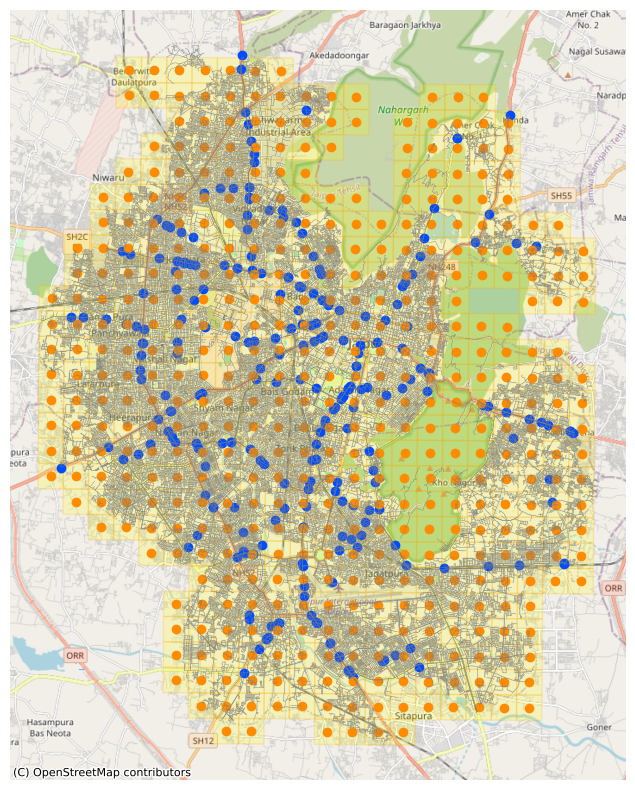

In [41]:
import matplotlib.pyplot as plt
import contextily as ctx

# Assuming 'edges', 'bus_stop', and 'grid' are your GeoDataFrames and have been correctly defined and imported

# Reprojecting your GeoDataFrames to Web Mercator (EPSG:3857) for consistency with the basemap
road_network = edges.to_crs(epsg=3857)
sap = bus_stop.to_crs(epsg=3857)
grid_1 = grid.to_crs(epsg=3857)
poi = gpd.GeoSeries(grid['POI'], crs='EPSG:4326').to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot road network first with reduced line width (linewidth or lw)
road_network.plot(ax=ax, color='grey', alpha=0.8, linewidth=0.2)

# Plot grid_1 with a different edge color and transparency over the road network
grid_1.plot(ax=ax, color='yellow', edgecolor='orange', alpha=0.2)

# Plot sap and poi over the road network and grid_1
sap.plot(ax=ax, color='#004CFF')
poi.plot(ax=ax, color='#FF8C00')

# Adding the OpenStreetMap basemap
provider = ctx.providers.OpenStreetMap.Mapnik
ctx.add_basemap(ax, source=provider)

# Removing axis for a cleaner look
ax.set_axis_off()

plt.show()


In [10]:
# set service points (bus stops) as destination
destinations = bus_stop.to_crs(nodes.crs)
# link the nearest node in street network
destinations = get_nearest_nodes(destinations, streets_graph)

100%|██████████| 256/256 [02:33<00:00,  1.66it/s]


In [11]:
# set grid centroids as origin points (assuming to be starting point of the trips)
origins = grid.to_crs(nodes.crs)
origins.dropna(inplace=True)
# link the nearest node in street network
origins = get_nearest_nodes(origins, streets_graph)

100%|██████████| 461/461 [04:35<00:00,  1.67it/s]


In [12]:
# impute missing edge speeds and calculate edge travel times with the speed module
streets_graph = ox.speed.add_edge_speeds(streets_graph)
streets_graph = ox.speed.add_edge_travel_times(streets_graph)

In [13]:
city_grid = nearest_sap(origins, destinations)

100%|██████████| 461/461 [00:03<00:00, 116.20it/s]


In [ ]:
city_grid.info()

Not all grids are allocated with a service access point. Therefore, service access points to those grids are assigned manually. This is done plotting the grids without any service access point allocated to them and picking the nearest sap from the interactive plot below.

In [ ]:
# Plot the choropleth map of grids without the nearest SAP allocated to them and overlay the plot with SAPs
plot_choropleth_sap_poi(gdf=city_grid, value_column='nearest_sap', sap=bus_stop)

In [76]:
missing_values = {
    131: 'GANGA JAMUNA',
    177: 'SANGANER TOWN',
    190: 'CHINKARA',
    209: 'GANDHI NAGAR',
    206: 'MAHAVEER NAGAR',
    263: 'DHARAM SINGH CIRCLE',
    317: 'KUNDA',
    318: 'KUNDA',
    341: 'KUNDA',
    342: 'KUNDA',
    343: 'KUNDA',
    365: 'KUNDA',
    366: 'KUNDA',
    367: 'KUNDA',
    368: 'KUNDA',
    390: 'KUNDA',
    456: 'TILAK HOSPITAL',
    457: 'TILAK HOSPITAL'
}

# Update the GeoDataFrame with the missing values
for idx, value in missing_values.items():
    city_grid.loc[idx, 'sap_name'] = value

# List of columns to fill NaN values
columns_to_fill = ['nearest_sap', 'destination', ]

# Fill NaN values within each 'sap_name' group
for column in columns_to_fill:
    city_grid[column] = city_grid.groupby('sap_name')[column].transform(lambda x: x.ffill().bfill())

# Reset the name of the nearest SAP
missing_values = {
    131: 'GURJAR KI THADI',
    177: 'DEVLIYA',
    190: 'PANIPECH',
    209: 'TONK PHATAK',
    206: 'JAWAHAR CIRCLE',
    263: 'SMS',
    317: 'AMBER',
    318: 'AMBER',
    341: 'AMBER',
    342: 'AMBER',
    343: 'AMBER',
    365: 'AMBER',
    366: 'AMBER',
    367: 'AMBER',
    368: 'AMBER',
    390: 'AMBER',
    456: 'TILAK HOSPITAL',
    457: 'TILAK HOSPITAL'
}

# Update the GeoDataFrame with the missing values
for idx, value in missing_values.items():
    city_grid.loc[idx, 'sap_name'] = value

city_grid['routes'] = city_grid.groupby('sap_name')['routes'].transform(lambda x: x.ffill().bfill())

In [77]:
city_grid.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 461 entries, 0 to 460
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   geometry          461 non-null    geometry
 1   POI               461 non-null    geometry
 2   address           0 non-null      float64 
 3   node              461 non-null    int64   
 4   nearest_sap       461 non-null    object  
 5   destination       461 non-null    float64 
 6   sap_name          461 non-null    object  
 7   routes            445 non-null    object  
 8   walking_distance  461 non-null    int64   
 9   WT                461 non-null    float64 
dtypes: float64(3), geometry(2), int64(2), object(3)
memory usage: 36.1+ KB


## 4. Calculate the route from POI to SAP and Walking Time (WT)

In [73]:
# calculate the shortest path to walk to the nearest SAP
city_grid = get_walking_route(graph=streets_graph, trips=city_grid)

100%|██████████| 461/461 [00:01<00:00, 357.44it/s]


In [74]:
# walking speed is assumed to be 3.6 kmph
walking_speed = 3.6
# convert walking speed to m/min
walking_speed = walking_speed * 16.6666667

city_grid = city_grid.replace(r'^\s*$', np.nan, regex=True)
city_grid['WT'] = city_grid['walking_distance'] / walking_speed

In [75]:
# fill the nan with mode
city_grid['WT'].isna().fillna(city_grid['WT'].mode()[0], inplace=True)

## 5. Calculate average waiting time at each SAP

In [78]:
# read routes of jctsl
bus_routes = pd.read_excel('../data/routes/jctsl_routes.xlsx')
bus_routes.route_no = bus_routes.route_no.astype(str)

In [79]:
# calculate the minimum waiting time for each stop
city_grid['service_frequency'] = ''
city_grid['routes'] = city_grid['routes'].astype(str)
for index, row in tqdm(city_grid[city_grid.routes != 'nan'].iterrows(),
                       total=len(city_grid[city_grid.routes != 'nan'])):
    frequency = {}
    for route_no in row.routes.split(','):
        route_no = route_no.strip()
        route_freq = bus_routes.loc[bus_routes['route_no'] == route_no, 'frequency'].item()
        frequency[route_no] = route_freq
    city_grid.loc[index, 'service_frequency'] = min(frequency.values())

city_grid.service_frequency.replace(r'^\s*$', np.nan, regex=True, inplace=True)
city_grid['service_frequency'] = city_grid.groupby('sap_name')['service_frequency'].fillna(method='ffill').fillna(method='bfill')

100%|██████████| 445/445 [00:00<00:00, 1897.04it/s]


In [80]:
# Calculate Average Waiting Time (AWT) for each SAP
city_grid['AWT'] = city_grid.service_frequency / 2 + 4
city_grid['TAT'] = city_grid['WT'] + city_grid['AWT']
city_grid['EDF'] = 30 / city_grid['TAT']

## 6. Calculate Accessibility index for each POI

In [81]:
# High frequency routes have weighing factor of 1; other routes have a weight of 0.5
route_name = '3A'
city_grid['weighing_factor'] = 0.5
city_grid.loc[city_grid.service_frequency == city_grid.service_frequency.min(), 'weighing_factor'] = 1

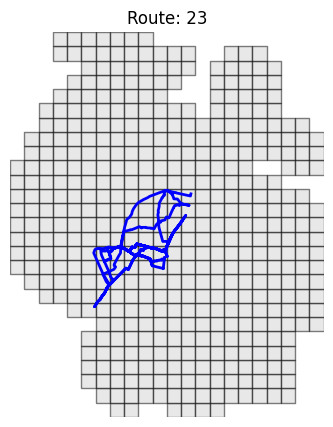

In [100]:
route_name = '23'
route_geometry = get_route_geometry(G=streets_graph, bus_stop=destinations,route_name=route_name, city_grid=city_grid, plot=True)

In [123]:
route_names = list(bus_routes.dropna().route_no.unique())

In [124]:
for route_name in route_names:
    route_geometry = get_route_geometry(G=streets_graph, bus_stop=destinations,route_name=route_name, city_grid=city_grid, plot=False)
    # Convert to GeoJSON format
    route_geojson = json.dumps(route_geometry.__geo_interface__)

    # Save GeoJSON string to disk
    with open(f'../data/routes/route_{route_name}.geojson', 'w') as f:
       f.write(route_geojson)


In [125]:
route_names

['3',
 '23',
 'AC1',
 'AC2',
 '16',
 '27A',
 '26',
 '1',
 '7',
 '9A',
 'AC3',
 '15',
 '28',
 '32',
 '24',
 '34',
 '1A',
 '3A',
 '10B',
 'AC8',
 'AC7',
 '30',
 'AC5',
 '11',
 '18',
 '6A',
 '4A']

In [45]:
city_grid['accessibility_index'] = city_grid['weighing_factor'] * city_grid['EDF']

In [46]:
gdf = reset_crs(city_grid)

# Create the choropleth map using Plotly Graph Objects
fig = go.Figure(go.Choroplethmapbox(geojson=gdf.geometry.__geo_interface__,
                                    locations=gdf.index,
                                    z=gdf['accessibility_index'],
                                    hovertext=gdf['sap_name'],
                                    colorscale='sunsetdark',
                                    zmin=0,
                                    zmax=gdf['EDF'].quantile(0.9),
                                    marker_opacity=0.6,
                                    )
                )

# Set the Mapbox token and layout
mapbox_token = get_mapbox_token()
fig.update_layout(
    title_text='Choropleth Map: Accessibility Index',
    mapbox_style='mapbox://styles/mapbox/streets-v12',
    mapbox_accesstoken=mapbox_token,
    mapbox_zoom=10,  # Adjust the initial zoom level
    mapbox_center={'lat': 26.933985, 'lon': 75.873857},
    coloraxis_colorbar=dict(
        title='Accessibility Index',
        thickness=20,
        lenmode='fraction',
        len=0.5,
        yanchor='top',
        y=0.98,
        tickfont=dict(size=10),
        ticksuffix=' units',
        dtick=10)
)

fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.write_html('../figures/AI-bus.html',
               full_html=False,
               include_plotlyjs='cdn')
fig.show()


In [47]:
city_grid = reset_crs(city_grid)

In [48]:
# store data to a csv file
city_grid.to_csv("../data/ai/ai_jctsl.csv", index=False, encoding='utf-8', header=True)

# Write the CRS information to a separate file
with open("../data/ai/ai_jctsl.csv".replace('.csv', '.prj'), 'w') as prj_file:
    prj_file.write(city_grid.crs.to_wkt())

In [95]:
# Convert to GeoJSON format
route_geojson = json.dumps(route_geometry.__geo_interface__)

# Save GeoJSON string to disk
with open(f'../data/routes/route_{route_name}.geojson', 'w') as f:
    f.write(route_geojson)

In [50]:
from shapely.geometry import shape
# Load GeoJSON string from disk
with open(f'../data/routes/route_{route_name}.geojson', 'r') as f:
    route_geojson = f.read()

# Convert GeoJSON string back to a LineString object
route_geojson = shape(json.loads(route_geojson))